References:
- [elastropy's playlist on Physics Informed Neural Networks](https://youtube.com/playlist?list=PLM7DTyYjZGuLmg3f6j40fEF18jyQmYsC2&si=35a-jywar0nasELh)

# Physics Informed Neural Networks (PINNs)

## Problem Definition - Poisson's Equation in One Dimension

Let's consider a simple boundary value problem (BVP) "**Poisson's equation in one dimension**" defined by the following ordinary differential equation (ODE):

$$\frac{d^2y}{dx^2} + \pi^2 sin(\pi x) = 0, \quad x \in [-1, 1]$$

Boundary conditions are: 
$$y(-1) = 0, \quad y(1) = 0$$

The analytical solution to this problem is:
$$y(x) = sin(\pi x)$$

## Role of PINNs

Neural networks are universal function approximators, which means they can approximate any function given enough neurons and appropriate training strategy. In the context of PINNs, we use neural networks to approximate the solution of differential equations by minimizing a loss function that incorporates both the differential equation and the boundary conditions. 

In this notebook, we will implement a PINN to approximate the solution to the above ODE:
$$y(x) \approx \hat{y}(x)$$

, where $\hat{y}$ is the output of a neural network.

## Loss functions

There are three main components to the loss function in a PINN:

#### 1. Data Loss
This term measures the difference between the predicted solution and the true solution at given data points. For example, if we have a set of data points $(x_i, y_i)$, the data loss can be defined as:
$$\text{Data Loss} = \mathcal{L}_{data} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}(x_i) - y_i)^2$$

where $N$ is the number of data points.

#### 2. ODE Loss
This term measures how well the neural network satisfies the differential equation. It is computed by evaluating the neural network at a set of collocation points and calculating the residual of the ODE. For our example, the ODE loss can be defined as:

\begin{align*}
\text{ODE Loss} = \mathcal{L}_{ODE} &= \frac{1}{M} \sum_{j=1}^{M} \left( \frac{d^2\hat{y}}{dx^2}(x_j) - \frac{d^2y}{dx^2}(x_j) \right)^2 \\ \\
&= \frac{1}{M} \sum_{j=1}^{M} \left( \frac{d^2\hat{y}}{dx^2}(x_j) + \pi^2 \sin(\pi x_j)
\right)^2 \quad \left( \because \frac{d^2y}{dx^2}(x_j) = -\pi^2 \sin(\pi x_j) \right) \\
\end{align*}


,where $M$ is the number of collocation points sampled from the domain $[-1, 1]$

#### 3. Boundary Loss
This term ensures that the neural network satisfies the boundary conditions. For our example, the boundary loss can be defined as:

\begin{align*}
\text{Boundary Loss} = \mathcal{L}_{boundary} &= (\hat{y}(-1) - y(-1))^2 + (\hat{y}(1) - y(1))^2 \\
&= (\hat{y}(-1) - 0)^2 + (\hat{y}(1) - 0)^2 \\
&= \hat{y}(-1)^2 + \hat{y}(1)^2 \\
\end{align*}

#### 4. Total Loss
The total loss function is a weighted sum of the three components:

$$\mathcal{L}_{total} = \lambda_1 \cdot \mathcal{L}_{data} + \lambda_2 \cdot \mathcal{L}_{ODE} + \lambda_3 \cdot \mathcal{L}_{boundary}$$

$$\text{OR}$$

$$\text{Total Loss} = \lambda_1 \cdot \text{Data Loss} + \lambda_2 \cdot \text{ODE Loss} + \lambda_3 \cdot \text{Boundary Loss}$$

where $\lambda_1$, $\lambda_2$, and $\lambda_3$ are hyperparameters that control the relative importance of each term.

### Role of Collocation Points

Collocation points are specific points in the domain where the ODE and boundary conditions are enforced. 
- **Why use collocation points?**
  - They allow the neural network to learn the underlying physics of the problem by minimizing the residuals of the ODE at these points.
  - They help in ensuring that the neural network approximates the solution accurately across the entire domain, not just at the data points.
- **How to choose collocation points?**
  - Collocation points can be chosen uniformly across the domain or based on specific criteria (e.g., clustering, adaptive sampling).

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

# from scipy.integrate import solve_bvp
from tqdm import tqdm
import gc

# plot settings
plt.close("all")
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 10
plt.rcParams["figure.dpi"] = 100

print("imports done!")

imports done!


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [5]:
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(PINN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, output_dim),
        )
        
    def forward(self, x):
        return self.model(x)


print("physics-informed neural network created!")

physics-informed neural network created!


In [6]:
# Automatic differentiation
def derivative(y, x):
    """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]


print("automatic differentiation function created!")

automatic differentiation function created!


In [7]:
def loss_function(model, x, y, x_bc, y_bc, lambda_data, lambda_ode, lambda_bc):
    # make a fresh copy of x that requires grads
    # we must do this before passing x through the model
    # otherwise the forward-graph will already be built
    x_coll = x.clone().detach().requires_grad_(True)
    
    # Data loss
    y_pred = model(x)
    data_loss = torch.mean((y_pred - y)**2)

    # ODE loss
    y_coll = model(x_coll)
    y_x = derivative(y_coll, x_coll)   # dy/dx
    y_xx = derivative(y_x, x_coll)     # d2y/dx2
    ode_loss = torch.mean((y_xx + torch.pi**2 * torch.sin(torch.pi * x_coll))**2)

    # Boundary loss
    # boundary_loss = (model(torch.tensor([-1.0]))**2 + model(torch.tensor([1.0]))**2)
    y_bc_pred = model(x_bc)
    boundary_loss = torch.mean((y_bc_pred - y_bc)**2)

    return lambda_data*data_loss + lambda_ode*ode_loss + lambda_bc*boundary_loss


print("loss function created!")

loss function created!


In [8]:
def train(model, x_data, y_data, x_bc, y_bc, lambda_data, lambda_ode, lambda_bc, epochs=10000, learning_rate=0.001, device="cpu"):
    model = model.to(device)
    x_data = x_data.to(device)
    y_data = y_data.to(device)
    x_bc = x_bc.to(device)
    y_bc = y_bc.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in tqdm(range(epochs)):
        model.train()
        optimizer.zero_grad()
        loss = loss_function(model, x_data, y_data, x_bc, y_bc, lambda_data, lambda_ode, lambda_bc)
        loss.backward()
        optimizer.step()
        
        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return model


print("training function created!")

training function created!


In [12]:
# Generate training data
def generate_data(num_points=1000):
    # generate evenly spaced points from the domain [-1,1]
    x_data = torch.linspace(-1, 1, num_points).view(-1, 1)    # collocation points
    y_data = torch.sin(np.pi * x_data) / np.pi
    x_bc = torch.tensor([[-1.0], [1.0]])
    y_bc = torch.tensor([[0.0], [0.0]])
    return x_data, y_data, x_bc, y_bc


print("data generation functions created!")

data generation functions created!


  1%|          | 19/2000 [00:00<00:22, 89.84it/s]

Epoch 0, Loss: 970.1165161132812


 51%|█████     | 1019/2000 [00:11<00:10, 97.04it/s]

Epoch 1000, Loss: 0.0010168430162593722


100%|██████████| 2000/2000 [00:21<00:00, 93.61it/s] 


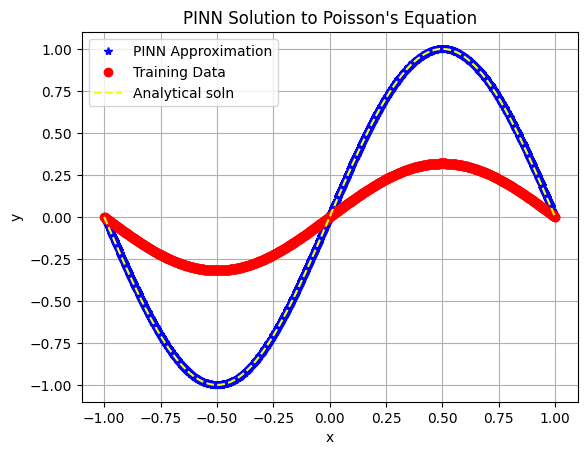

In [18]:
# Main function to run the PINN
def main():
    # Hyperparameters
    input_dim = 1
    output_dim = 1
    hidden_units = 50
    epochs = 2000
    learning_rate = 0.001
    lambda_data = 0.0
    lambda_ode = 20.0
    lambda_bc = 5.0

    # Generate training data and collocation points
    x_data, y_data, x_bc, y_bc = generate_data()

    # Initialize the PINN model
    model = PINN(input_dim, hidden_units, output_dim)

    # Train the model
    trained_model = train(model, x_data, y_data, x_bc, y_bc, lambda_data, lambda_ode, lambda_bc, epochs, learning_rate, device)

    # Plot the results
    x_plot = torch.linspace(-1, 1, 1000, device=device).view(-1, 1)
    y_plot = trained_model(x_plot).cpu().detach().numpy()
    analytical_soln = np.sin(np.pi * x_plot).cpu().detach().numpy()
    
    plt.plot(x_plot.cpu().numpy(), y_plot, 'b*', label='PINN Approximation')
    plt.plot(x_data.cpu().numpy(), y_data.cpu().numpy(), 'ro', label='Training Data')
    plt.plot(x_plot.cpu().numpy(), analytical_soln, '--', color='yellow', label="Analytical soln")
    plt.title('PINN Solution to Poisson\'s Equation')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid()
    plt.show()


if __name__ == "__main__":
    main()

In [19]:
gc.collect()
print("freed up some memory")

freed up some memory
